In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Wczytanie danych
adult = pd.read_csv("adultData.csv")

# Ujednolicenie nazw kolumn - spacja przed nazwami kolumn
adult.columns = adult.columns.str.strip()

# kolumna finalweight nie jest potrzebna
adult = adult.drop(columns=["fnlwgt"], errors="ignore")
print(adult.columns)

# Zmiana znaków '?' na NaN w całym DataFrame. Plik był w formacie ".data" więc trzeba było najpierw zamienić " ?" na NaN
adult.replace([" ?", "?"], np.nan, inplace=True)

# Podsumowanie braków
null_counts = adult.isna().sum()
print("Braki wg kolumn:\n", null_counts)

adult.head(5)

Index(['age', 'workclass', 'education', 'education-num', 'marital-status',
       'occupation', 'relationship', 'race', 'sex', 'capital-gain',
       'capital-loss', 'hours-per-week', 'native-country', 'income'],
      dtype='object')
Braki wg kolumn:
 age                  0
workclass         1836
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64


,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [18]:
# 1) Opis zbioru danych

def opis_zbioru(df: pd.DataFrame, nazwa: str = "adult") -> None:
    n_rows, n_cols = df.shape
    total_missing = int(df.isna().sum().sum())
    missing_pct = (total_missing / (n_rows * n_cols) * 100) if (n_rows * n_cols) else 0.0

    print(f"Opis zbioru danych: {nazwa}")
    print(f"- Liczba obserwacji (wierszy): {n_rows}")
    print(f"- Liczba zmiennych (kolumn): {n_cols}")
    print(f"- Łączna liczba braków danych: {total_missing} ({missing_pct:.2f}% wszystkich pól)")
    print("- Typy danych (Pandas):")
    print(df.dtypes.value_counts())

opis_zbioru(adult, nazwa="adultData.csv (Adult)")


# 2) Skale pomiarowe

# Kolumny zwykle porządkowe w zbiorze Adult
ORDINAL_CANDIDATES = {
    "education": "porządkowa",
    "education-num": "ilorazowa",  # liczba lat edukacji/poziom jako liczba: traktowane ilościowo
}

# Kolumny zwykle ilościowe (ilorazowe)
RATIO_CANDIDATES = {
    "age": "ilorazowa",
    "capital-gain": "ilorazowa",
    "capital-loss": "ilorazowa",
    "hours-per-week": "ilorazowa",
    "education-num": "ilorazowa",
}

# Kolumny zwykle nominalne (kategorie bez porządku)
NOMINAL_CANDIDATES = {
    "workclass": "nominalna",
    "occupation": "nominalna",
    "native-country": "nominalna",
    "marital-status": "nominalna",
    "relationship": "nominalna",
    "race": "nominalna",
    "sex": "nominalna",
    "income": "nominalna", # docelowa zmienna binarna
    "salary": "nominalna",
    "class": "nominalna",
}

def typ_analityczny(series: pd.Series) -> str:
    if pd.api.types.is_numeric_dtype(series):
        return "ilościowa"
    return "jakościowa"

def skala_pomiarowa(df: pd.DataFrame, col: str) -> str:
    # 1) ręczne mapowania
    if col in ORDINAL_CANDIDATES:
        return ORDINAL_CANDIDATES[col]
    if col in RATIO_CANDIDATES:
        return RATIO_CANDIDATES[col]
    if col in NOMINAL_CANDIDATES:
        return NOMINAL_CANDIDATES[col]

    # 2) heurystyka: liczby -> ilorazowa, reszta -> nominalna
    if pd.api.types.is_numeric_dtype(df[col]):
        return "ilorazowa"
    return "nominalna"


#  3) Tabela charakterystyki zmiennych (typy + skale + braki + unikatowość)

def charakterystyka_zmiennych(df: pd.DataFrame, sample_n: int = 5) -> pd.DataFrame:
    rows = []
    n = len(df)

    for col in df.columns:
        s = df[col]
        pandas_dtype = str(s.dtype)
        analityczny = typ_analityczny(s)
        skala = skala_pomiarowa(df, col)

        missing = int(s.isna().sum())
        missing_pct = (missing / n * 100) if n else 0.0

        nunique = int(s.nunique(dropna=True))
        nunique_incl_nan = int(s.nunique(dropna=False))

        # przykładowe wartości (bez NaN)
        examples = s.dropna().astype(str).unique()[:sample_n].tolist()

        rows.append({
            "zmienna": col,
            "typ_pandas": pandas_dtype,
            "typ_analityczny": analityczny,
            "skala_pomiarowa": skala,
            "unikaty_bez_NaN": nunique,
            "unikaty_z_NaN": nunique_incl_nan,
            "braki_NaN": missing,
            "braki_%": round(missing_pct, 2),
            "przykładowe_wartości": ", ".join(examples),
        })

    meta = pd.DataFrame(rows).sort_values(["typ_analityczny", "zmienna"]).reset_index(drop=True)
    return meta

meta = charakterystyka_zmiennych(adult, sample_n=6)
display(meta)


Opis zbioru danych: adultData.csv (Adult)
- Liczba obserwacji (wierszy): 32561
- Liczba zmiennych (kolumn): 14
- Łączna liczba braków danych: 4262 (0.93% wszystkich pól)
- Typy danych (Pandas):
object    9
int64     5
Name: count, dtype: int64


,zmienna,typ_pandas,typ_analityczny,skala_pomiarowa,unikaty_bez_NaN,unikaty_z_NaN,braki_NaN,braki_%,przykładowe_wartości
0,age,int64,ilościowa,ilorazowa,73,73,0,0.00,"39, 50, 38, 53, 28, 37"
1,capital-gain,int64,ilościowa,ilorazowa,119,119,0,0.00,"2174, 0, 14084, 5178, 5013, 2407"
2,capital-loss,int64,ilościowa,ilorazowa,92,92,0,0.00,"0, 2042, 1408, 1902, 1573, 1887"
3,education-num,int64,ilościowa,ilorazowa,16,16,0,0.00,"13, 9, 7, 14, 5, 10"
4,hours-per-week,int64,ilościowa,ilorazowa,94,94,0,0.00,"40, 13, 16, 45, 50, 80"
5,education,object,jakościowa,porządkowa,16,16,0,0.00,"Bachelors, HS-grad, 11th, Masters, 9th, ..."
6,income,object,jakościowa,nominalna,2,2,0,0.00,"<=50K, >50K"
7,marital-status,object,jakościowa,nominalna,7,7,0,0.00,"Never-married, Married-civ-spouse, Divorced..."
8,native-country,object,jakościowa,nominalna,41,42,583,1.79,"United-States, Cuba, Jamaica, India, Mexi..."
9,occupation,object,jakościowa,nominalna,14,15,1843,5.66,"Adm-clerical, Exec-managerial, Handlers-cle..."


Cramér’s V (occupation vs workclass): 0.215
Cramér’s V (occupation vs sex): 0.434
Cramér’s V (occupation vs race): 0.080
Cramér’s V (occupation vs education): 0.196
Cramér’s V (workclass vs occupation): 0.215
Cramér’s V (workclass vs sex): 0.143
Cramér’s V (workclass vs race): 0.055
Cramér’s V (workclass vs education): 0.100


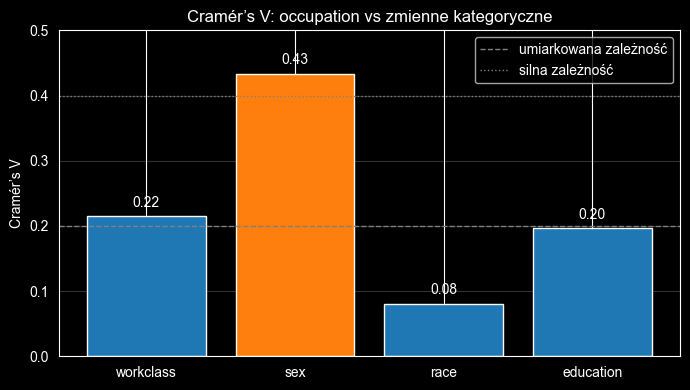

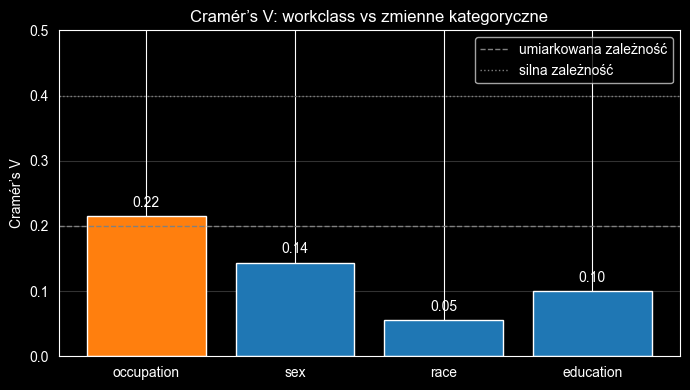

In [19]:
# ANALIZA ZALEŻNOŚCI (UZASADNIENIE WYBORU METODY IMPUTACJI)
# Sprawdzenie, czy imputacja warunkowa zmiennej 'occupation'
# ma statystyczne uzasadnienie.
# Metoda:
# Cramér’s V – miara zależności kategoria–kategoria
# (occupation vs inne zmienne kategoryczne)
# Interpretacja Cramér’s V:
# < 0.2   → słaba zależność
# 0.2–0.4 → umiarkowana zależność
# > 0.4   → silna zależność
# ============================================================

from scipy.stats import chi2_contingency

def cramers_v(x, y):
    """Oblicza miarę Cramér’s V dla dwóch zmiennych kategorycznych"""
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n

    r, k = confusion_matrix.shape
    phi2_corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    r_corr = r - ((r - 1) ** 2) / (n - 1)
    k_corr = k - ((k - 1) ** 2) / (n - 1)

    return np.sqrt(phi2_corr / min(k_corr - 1, r_corr - 1))

# ============================================================
# 2. Cramér’s V: occupation i workclass vs inne zmienne kategoryczne
# ============================================================

categorical1_vars = ["workclass", "sex", "race", "education"]

for col in categorical1_vars:
    v = cramers_v(
        adult["occupation"].dropna(),
        adult.loc[adult["occupation"].notna(), col]
    )
    print(f"Cramér’s V (occupation vs {col.strip()}): {v:.3f}")

categorical2_vars = ["occupation", "sex", "race", "education"]

for col in categorical2_vars:
    v = cramers_v(
        adult["workclass"].dropna(),
        adult.loc[adult["workclass"].notna(), col]
    )
    print(f"Cramér’s V (workclass vs {col.strip()}): {v:.3f}")

# PODSUMOWANIE ANALIZY
# - Najsilniejszą zależność kategoria–kategoria z occupation
#   wykazują zmienne: workclass oraz education.
# - Zależności te są umiarkowane, dlatego same zmienne
#   kategoryczne nie są wystarczające do imputacji.
# - W połączeniu z bardzo silną zależnością liczbową
#   (education-num, ANOVA) uzasadnione jest zastosowanie
#   imputacji warunkowej / predykcyjnej (np. Hot Deck,
#   KNN lub model klasyfikacyjny).

import matplotlib.pyplot as plt

# Oblicz wartości Cramér’s V dla wszystkich zmiennych kategorycznych
categorical1_vars = ["workclass", "sex", "race", "education"]
cramers1_v_values = []

for col in categorical1_vars:
    v = cramers_v(
        adult["occupation"].dropna(),
        adult.loc[adult["occupation"].notna(), col]
    )
    cramers1_v_values.append(v)

# Wykres słupkowy
plt.figure(figsize=(7, 4))
bars = plt.bar(categorical1_vars, cramers1_v_values, color=["#1f77b4" if v < max(cramers1_v_values) else "#ff7f0e" for v in cramers1_v_values])
plt.title("Cramér’s V: occupation vs zmienne kategoryczne")
plt.ylabel("Cramér’s V")
plt.ylim(0, 0.5)
plt.axhline(0.2, color="gray", linestyle="--", linewidth=1, label="umiarkowana zależność")
plt.axhline(0.4, color="gray", linestyle=":", linewidth=1, label="silna zależność")
plt.legend()
plt.grid(axis="y", alpha=0.2)

# Podpisy wartości na słupkach
for bar, v in zip(bars, cramers1_v_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f"{v:.2f}", ha="center", va="bottom")

plt.tight_layout()
plt.show()

# Oblicz wartości Cramér’s V dla wszystkich zmiennych kategorycznych
categorical2_vars = ["occupation", "sex", "race", "education"]
cramers2_v_values = []

for col in categorical2_vars:
    v = cramers_v(
        adult["workclass"].dropna(),
        adult.loc[adult["workclass"].notna(), col]
    )
    cramers2_v_values.append(v)

plt.figure(figsize=(7, 4))
bars = plt.bar(categorical2_vars, cramers2_v_values, color=["#1f77b4" if v < max(cramers2_v_values) else "#ff7f0e" for v in cramers2_v_values])
plt.title("Cramér’s V: workclass vs zmienne kategoryczne")
plt.ylabel("Cramér’s V")
plt.ylim(0, 0.5)
plt.axhline(0.2, color="gray", linestyle="--", linewidth=1, label="umiarkowana zależność")
plt.axhline(0.4, color="gray", linestyle=":", linewidth=1, label="silna zależność")
plt.legend()
plt.grid(axis="y", alpha=0.2)

# Podpisy wartości na słupkach
for bar, v in zip(bars, cramers2_v_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f"{v:.2f}", ha="center", va="bottom")

plt.tight_layout()
plt.show()


In [20]:
# ANOVA — occupation vs wszystkie zmienne numeryczne
# Sprawdzamy, które zmienne różnicują zawody

from scipy.stats import f_oneway
import pandas as pd
import numpy as np

adult = pd.read_csv("adultData.csv")

# Porządki techniczne
adult.columns = adult.columns.str.strip()
adult.replace("?", np.nan, inplace=True)

# Wszystkie zmienne numeryczne
numerical_cols = adult.select_dtypes(include=np.number).columns

for col in numerical_cols:
    groups = [
        adult.loc[adult["occupation"] == occ, col]
        for occ in adult["occupation"].dropna().unique()
    ]
    f_stat, p_val = f_oneway(*groups)
    print(f"ANOVA (occupation vs {col}): F={f_stat:.2f}, p={p_val:.2e}")

# ANOVA — workclass vs wszystkie zmienne numeryczne
# Sprawdzamy, które zmienne różnicują zawody

from scipy.stats import f_oneway
import pandas as pd
import numpy as np

adult = pd.read_csv("adultData.csv")

# Porządki techniczne
adult.columns = adult.columns.str.strip()
adult.replace("?", np.nan, inplace=True)

# Wszystkie zmienne numeryczne
numerical_cols = adult.select_dtypes(include=np.number).columns

for col in numerical_cols:
    groups = [
        adult.loc[adult["workclass"] == occ, col]
        for occ in adult["workclass"].dropna().unique()
    ]
    f_stat, p_val = f_oneway(*groups)
    print(f"ANOVA (workclass vs {col}): F={f_stat:.2f}, p={p_val:.2e}")


ANOVA (occupation vs age): F=83.75, p=3.52e-237
ANOVA (occupation vs fnlwgt): F=7.14, p=5.05e-15
ANOVA (occupation vs education-num): F=1043.40, p=0.00e+00
ANOVA (occupation vs capital-gain): F=33.72, p=3.90e-91
ANOVA (occupation vs capital-loss): F=16.96, p=1.63e-42
ANOVA (occupation vs hours-per-week): F=249.71, p=0.00e+00
ANOVA (workclass vs age): F=203.74, p=0.00e+00
ANOVA (workclass vs fnlwgt): F=11.30, p=4.11e-16
ANOVA (workclass vs education-num): F=164.89, p=6.88e-274
ANOVA (workclass vs capital-gain): F=44.72, p=5.05e-72
ANOVA (workclass vs capital-loss): F=9.00, p=2.04e-12
ANOVA (workclass vs hours-per-week): F=223.51, p=0.00e+00


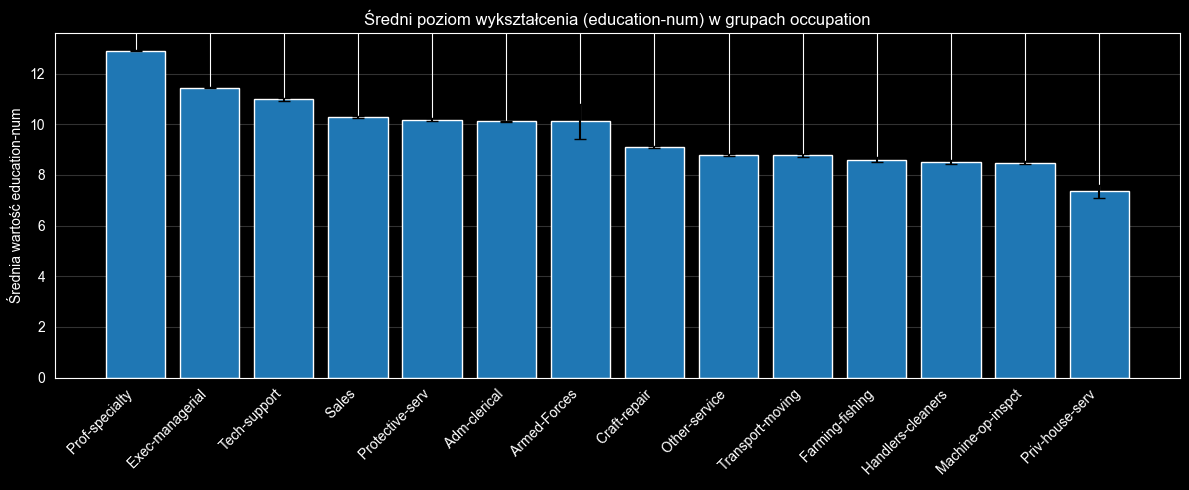

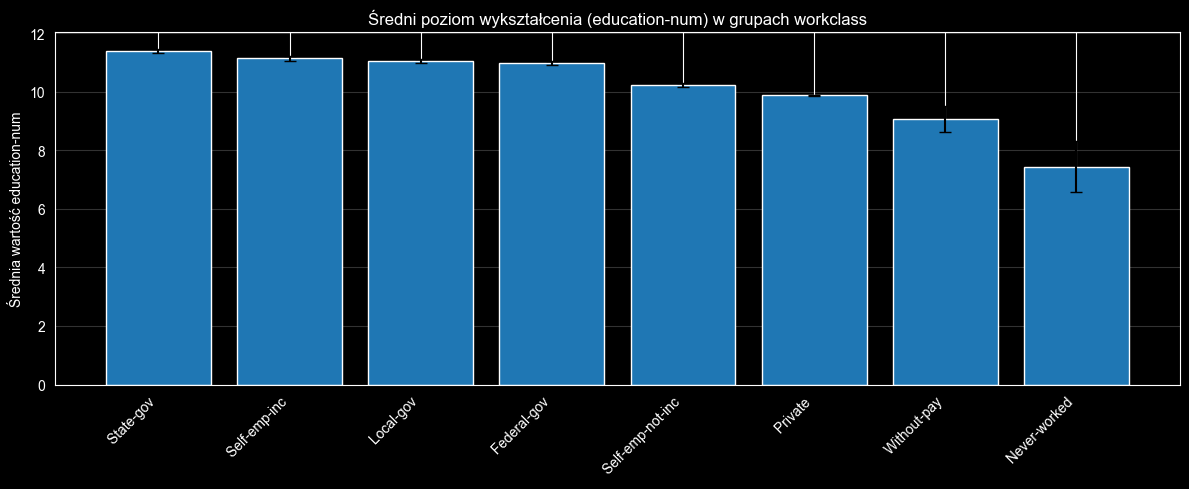

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Wczytanie i przygotowanie danych
adult = pd.read_csv('adultData.csv')
adult.columns = adult.columns.str.strip()
adult.replace([' ?', '?'], np.nan, inplace=True)

# Oblicz średnie i błędy standardowe dla education-num w grupach occupation
grouped = adult.groupby('occupation')['education-num']
means = grouped.mean()
stds = grouped.std()
counts = grouped.count()
sems = stds / np.sqrt(counts)

# Posortuj po średniej malejąco
means = means.sort_values(ascending=False)
sems = sems[means.index]

# Wykres słupkowy
plt.figure(figsize=(12, 5))
bars = plt.bar(means.index, means.values, yerr=sems.values, capsize=4, color="#1f77b4")
plt.ylabel('Średnia wartość education-num')
plt.title('Średni poziom wykształcenia (education-num) w grupach occupation')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', alpha=0.2)
plt.show()

#WORKCLASS
# Wczytanie i przygotowanie danych
adult = pd.read_csv('adultData.csv')
adult.columns = adult.columns.str.strip()
adult.replace([' ?', '?'], np.nan, inplace=True)

# Oblicz średnie i błędy standardowe dla education-num w grupach occupation
grouped = adult.groupby('workclass')['education-num']
means = grouped.mean()
stds = grouped.std()
counts = grouped.count()
sems = stds / np.sqrt(counts)

# Posortuj po średniej malejąco
means = means.sort_values(ascending=False)
sems = sems[means.index]

# Wykres słupkowy
plt.figure(figsize=(12, 5))
bars = plt.bar(means.index, means.values, yerr=sems.values, capsize=4, color="#1f77b4")
plt.ylabel('Średnia wartość education-num')
plt.title('Średni poziom wykształcenia (education-num) w grupach workclass')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', alpha=0.2)
plt.show()
# Interpretacja jest czysto statystyczna i „pod kątem imputacji”:
# `occupation vs education-num`
# F ≈ 1043.4, p ≈ 0
# → ekstremalnie silne, istotne statystycznie zróżnicowanie poziomu wykształcenia między zawodami.
# Wniosek: education-num jest bardzo mocno powiązana z occupation, świetna zmienna do imputacji occupation.
# `occupation vs hours-per-week`
# F ≈ 249.7, p ≈ 0
# → bardzo silne różnice liczby godzin pracy między zawodami.
# Wniosek: godziny pracy też dobrze odróżniają zawody, mogą być użyte jako dodatkowa zmienna pomocnicza.
# `occupation vs age`
# F ≈ 83.8, p ≈ 3.5e-237
# → istotne, wyraźne różnice wieku między zawodami, ale słabsze niż dla education-num i hours-per-week.
# Wniosek: wiek ma znaczenie, ale jest mniej „charakterystyczny” dla zawodu niż edukacja i godziny.
# `occupation vs capital-gain`
# F ≈ 33.7, p ≈ 3.9e-91
# → istotne różnice w capital-gain między zawodami, ale efekt już wyraźnie słabszy.
# Wniosek: może wspierać imputację, ale nie jest kluczową zmienną.
# `occupation vs capital-loss`
# F ≈ 17.0, p ≈ 1.6e-42
# → też istotne statystycznie, ale najsłabszy efekt z wymienionych.
# Wniosek: raczej pomocnicza, mało „nośna” zmienna.
# Podsumowując:
# H0 („średnie są równe między zawodami”) jest odrzucona dla wszystkich zmiennych.
# Najsilniej z occupation związane są: `education-num` (zdecydowanie) i `hours-per-week`.
# Do imputacji occupation najbardziej sensownie użyć `education-num` jako głównego predyktora, a `hours-per-week`, `age`, ewentualnie `capital-gain/loss` jako uzupełnienie



In [23]:
# Wczytanie i przygotowanie danych
adult = pd.read_csv('adultData.csv')
adult.columns = adult.columns.str.strip()
adult.replace([' ?', '?'], np.nan, inplace=True)

# Hot Deck Imputacja occupation

np.random.seed(42)

# maska braków
missing_mask = adult["occupation"].isna()

# lista donorów
donors = adult.loc[~missing_mask]

# komórki do doboru dawcy (od najbardziej restrykcyjnych do globalnej)
cell_levels = [
    ["sex", "workclass", "education"],
    ["sex", "workclass"],
    ["education"],
    []  # globalny hot deck
]

# kolumna do oznaczenia imputacji
adult["occupation__imputed"] = False

# iteracja po brakach
for idx in adult.loc[missing_mask].index:
    for cols in cell_levels:
        if len(cols) == 0:
            pool = donors
        else:
            pool = donors.copy()
            for c in cols:
                pool = pool.loc[pool[c] == adult.at[idx, c]]

        if len(pool) > 0:
            donor = pool.sample(1)
            adult.at[idx, "occupation"] = donor["occupation"].values[0]
            adult.at[idx, "occupation__imputed"] = True
            break

# Sprawdzenie wyników
print("Braki przed imputacją:", missing_mask.sum())
print("Braki po imputacji:", adult["occupation"].isna().sum())
print("Liczba imputacji hot deck:", adult["occupation__imputed"].sum())


Braki przed imputacją: 1843
Braki po imputacji: 0
Liczba imputacji hot deck: 1843


In [24]:
import numpy as np
import pandas as pd

# Wczytanie i przygotowanie danych
adult = pd.read_csv('adultData.csv')
adult.columns = adult.columns.str.strip()
adult.replace([' ?', '?'], np.nan, inplace=True)

# -----------------------------
# Hot Deck Imputacja workclass
# -----------------------------
np.random.seed(42)

# maska braków
missing_mask = adult["workclass"].isna()

# lista donorów
donors = adult.loc[~missing_mask]

# komórki do doboru dawcy (od najbardziej restrykcyjnych do globalnej)
cell_levels = [
    ["sex", "occupation", "education"],  # mocne zależności z ANOVA / Cramér
    ["sex", "education"],
    ["sex"],
    ["education"],
    []  # globalny hot deck
]

# kolumna do oznaczenia imputacji
adult["workclass__imputed"] = False

# iteracja po brakach
for idx in adult.loc[missing_mask].index:
    for cols in cell_levels:
        if len(cols) == 0:
            pool = donors
        else:
            pool = donors.copy()
            for c in cols:
                pool = pool.loc[pool[c] == adult.at[idx, c]]

        if len(pool) > 0:
            donor = pool.sample(1)
            adult.at[idx, "workclass"] = donor["workclass"].values[0]
            adult.at[idx, "workclass__imputed"] = True
            break  # przerywamy po znalezieniu dawcy

# -----------------------------
# Sprawdzenie wyników
# -----------------------------
print("Braki przed imputacją:", missing_mask.sum())
print("Braki po imputacji:", adult["workclass"].isna().sum())
print("Liczba imputacji hot deck:", adult["workclass__imputed"].sum())


Braki przed imputacją: 1836
Braki po imputacji: 0
Liczba imputacji hot deck: 1836


In [25]:
def fill_with_group_mode(
    df: pd.DataFrame,
    target: str,
    by: list[str],
    fallback_mode: str | None = None
) -> pd.DataFrame:
    """
    Uzupełnia NaN w `target` modą w grupach `by`.
    Jeśli w grupie nie da się wyznaczyć mody, używa `fallback_mode` (domyślnie globalna moda).
    Dodaje flagę: f"{target}__imputed".
    """
    out = df.copy()
    miss = out[target].isna()

    if fallback_mode is None:
        non_na = out[target].dropna()
        fallback_mode = non_na.mode().iloc[0] if len(non_na) else np.nan

    def _mode_or_nan(x: pd.Series):
        x = x.dropna()
        if len(x) == 0:
            return np.nan
        m = x.mode()
        return m.iloc[0] if len(m) else np.nan

    group_mode = out.groupby(by, dropna=False)[target].transform(_mode_or_nan)

    out.loc[miss, target] = group_mode[miss]
    out[target] = out[target].fillna(fallback_mode)
    out[f"{target}__imputed"] = miss
    return out

adult_imputed = adult.copy()

adult_imputed = fill_with_group_mode(
    adult_imputed,
    target="native-country",
    by=["race"]
)

print("Braki po imputacji:\n", adult_imputed[[ "native-country"]].isna().sum())
print("Liczba imputacji:\n", adult_imputed[["native-country__imputed"]].sum())

Braki po imputacji:
 native-country    0
dtype: int64
Liczba imputacji:
 native-country__imputed    583
dtype: int64


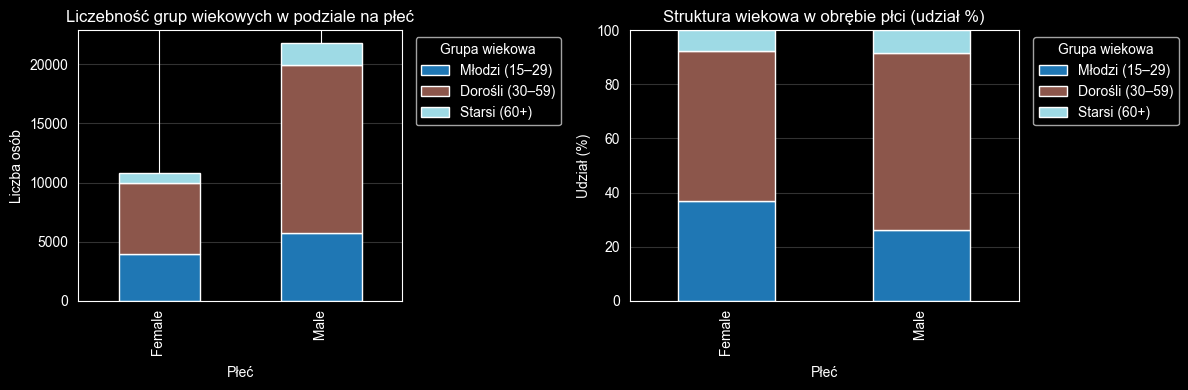

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Kopia danych + grupy wieku
adult_plot = adult.copy()

bins = [15, 29, 59, np.inf]
age_labels = ["Młodzi (15–29)", "Dorośli (30–59)", "Starsi (60+)"]

adult_plot["age_group"] = pd.cut(
    adult_plot["age"],
    bins=bins,
    labels=age_labels,
    right=True,
    include_lowest=True
)

# Dane: tylko potrzebne kolumny
d = adult_plot[["sex", "age_group"]].dropna()

# Tabela kontyngencji: płeć x grupa wieku (liczebności)
ct = pd.crosstab(d["sex"], d["age_group"]).reindex(columns=age_labels, fill_value=0)

# Procenty w obrębie płci (wiersze sumują się do 100%)
ct_pct = ct.div(ct.sum(axis=1), axis=0) * 100

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={"width_ratios": [1, 1.2]})

# (A) Liczebności: stacked bar
ct.plot(kind="bar", stacked=True, ax=axes[0], colormap="tab20")
axes[0].set_title("Liczebność grup wiekowych w podziale na płeć")
axes[0].set_xlabel("Płeć")
axes[0].set_ylabel("Liczba osób")
axes[0].grid(axis="y", alpha=0.2)
axes[0].legend(title="Grupa wiekowa", bbox_to_anchor=(1.02, 1), loc="upper left")

# (B) Udziały %: 100% stacked bar
ct_pct.plot(kind="bar", stacked=True, ax=axes[1], colormap="tab20")
axes[1].set_title("Struktura wiekowa w obrębie płci (udział %)")
axes[1].set_xlabel("Płeć")
axes[1].set_ylabel("Udział (%)")
axes[1].set_ylim(0, 100)
axes[1].grid(axis="y", alpha=0.2)
axes[1].legend(title="Grupa wiekowa", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()


In [28]:
# Binowanie zmiennej sex: Female → 0, Male → 1
# Będzie do późniejszego trenowania modelu, który będzie korzystał z płci jako cechy numerycznej
adult["sex"] = (adult["sex"] == " Male").astype(int)

print("Binowanie zmiennej sex:")
print(adult["sex"].value_counts().sort_index())

Binowanie zmiennej sex:
sex
0    32561
Name: count, dtype: int64
